## Sarcasm Detection - Unfrozen BERT + CNN

# Installation & Download

In [1]:
import warnings
%load_ext autoreload
%autoreload 2

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
except:
    IN_COLAB = False

In [3]:
if IN_COLAB:
  !pip install datasets
  !pip install transformers
  !pip install wandb

In [4]:
from torch.utils.data import Dataset
import pandas as pd
import numpy as np
import tqdm
import torch
import random
from sklearn import model_selection, feature_extraction
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from datasets import load_dataset, concatenate_datasets, load_metric, Dataset
from transformers import pipeline, AutoModel, BertTokenizer, BertModel, AutoConfig, AutoTokenizer, DataCollatorWithPadding
import os

In [5]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

In [6]:
# Source https://nlp.cs.princeton.edu/SARC/
!wget -nc 'https://nlp.cs.princeton.edu/SARC/0.0/key.csv'
!wget -nc 'https://nlp.cs.princeton.edu/SARC/0.0/main/test-balanced.csv.bz2'
!wget -nc 'https://nlp.cs.princeton.edu/SARC/0.0/main/train-balanced.csv.bz2'
!bzip2 -dk 'test-balanced.csv.bz2'
!bzip2 -dk 'train-balanced.csv.bz2'

File ‘key.csv’ already there; not retrieving.

File ‘test-balanced.csv.bz2’ already there; not retrieving.

File ‘train-balanced.csv.bz2’ already there; not retrieving.

bzip2: Output file test-balanced.csv already exists.
bzip2: Output file train-balanced.csv already exists.


# Load Data Set
Citation: https://medium.com/@therpsvishal/sarcasm-detection-on-reddit-data-4b399df855ad

In [7]:
# Get Train Data
header_names = pd.read_csv('key.csv', sep='\t').columns.values.tolist()
train = pd.read_csv('train-balanced.csv', sep='\t', names=header_names)
test = pd.read_csv('test-balanced.csv', sep='\t', names=header_names)

# Pre-processing

comments have lengths min:1.0, mean: 56.692298864334525, median: 46.0, max: 10000.0
parent_comments have lengths min:1, mean: 133.35310923937453, median: 75.0, max: 40301

Dropping 0.1% from min and max extremes we have:
comments have lengths min:1.0, mean: 56.05465451131691, median: 46.0, max: 363.0
parent_comments have lengths min:1.0, mean: 93.54131855580702, median: 70.0, max: 363.0


Text(0.5, 1.0, 'Parent Comments')

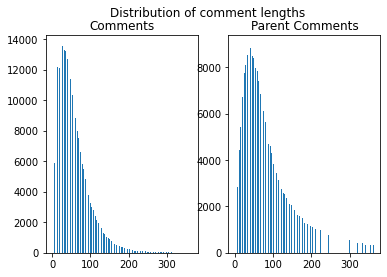

In [8]:
comment_lengths = train['comment'].str.len()
parent_lengths = train['parent_comment'].str.len()
print(
    f'comments have lengths min:{comment_lengths.min()}, mean: {comment_lengths.mean()}, median: {comment_lengths.median()}, max: {comment_lengths.max()}')
print(
    f'parent_comments have lengths min:{parent_lengths.min()}, mean: {parent_lengths.mean()}, median: {parent_lengths.median()}, max: {parent_lengths.max()}')

print('\nDropping 0.1% from min and max extremes we have:')
sorted_c = comment_lengths.sort_values()
lower_idx, upper_idx = int(0.001 * comment_lengths.size), int(0.999 * comment_lengths.size)
lower_bound, upper_bound = sorted_c.tolist()[lower_idx], sorted_c.tolist()[upper_idx]
t_comment_lengths = comment_lengths.where(lambda x: (lower_bound <= x) & (x <= upper_bound)).dropna()
print(
    f'comments have lengths min:{t_comment_lengths.min()}, mean: {t_comment_lengths.mean()}, median: {t_comment_lengths.median()}, max: {t_comment_lengths.max()}')

sorted_p = comment_lengths.sort_values()
lower_idx, upper_idx = int(0.001 * parent_lengths.size), int(0.999 * parent_lengths.size)
lower_bound, upper_bound = sorted_p.tolist()[lower_idx], sorted_p.tolist()[upper_idx]
t_parent_lengths = parent_lengths.where(lambda x: (lower_bound <= x) & (x <= upper_bound)).dropna()
print(
    f'parent_comments have lengths min:{t_parent_lengths.min()}, mean: {t_parent_lengths.mean()}, median: {t_parent_lengths.median()}, max: {t_parent_lengths.max()}')

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Distribution of comment lengths')
ax1.hist(t_comment_lengths.tolist(), bins=1000)
ax1.set_title('Comments')
ax2.hist(t_parent_lengths.tolist(), bins=1000)
ax2.set_title('Parent Comments')

# train_df['comment_length'] = train_df['comment'].str.len()
# train_df.hist(bins=100,column='comment_length')
#comment_lengths.hist(bins=100)

## Convolutional Neural Network (CNN)

In [9]:
# CNN Code Here
dirs = ['cnn', 'cnn/cache', 'cnn/runs', 'cnn/models']
_, cache_dir, run_dir, model_dir = dirs
seed = 777
max_length = 512
batch_size = 1
data_percentage = 0.1 # Value in the range (0,1] to determine how much data to use for training.
#model_name = 'facebook/bart-base'
model_name = 'bert-base-uncased'
run_id = ''
project_name = 'cs263-nlp-final'
tokenizer = AutoTokenizer.from_pretrained(model_name)

if IN_COLAB:
  from requests import get
  filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
  notebook_name = filename.split('.')[0]
  save_path = f'/content/drive/MyDrive/Colab Notebooks/{notebook_name}-outputs'

else:
  save_path = '.'

print(f'Saving experiment results to {save_path}')

dirs = [save_path, f'{save_path}/cnn', f'{save_path}/cnn/cache', f'{save_path}/cnn/runs', f'{save_path}/cnn/models']
_, _, cache_dir, run_dir, model_dir = dirs

for d in dirs:
    if not os.path.exists(d):
        os.mkdir(d)

Saving experiment results to .


In [10]:
dataset = Dataset.from_pandas(train)
subset = dataset.train_test_split(test_size=data_percentage, seed=seed)['test']
combined = [f'{p_c}{tokenizer.sep_token}{c}' for p_c, c in tqdm.tqdm(zip(subset['parent_comment'], subset['comment']))]
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
trainable_set = subset.add_column('comment_pair', combined)
print(trainable_set[0])

101083it [00:00, 960087.75it/s]


Flattening the indices:   0%|          | 0/102 [00:00<?, ?ba/s]

{'label': 1, 'comment': 'It was secretly designed by the Japanese!', 'author': 'DemonicSquid', 'subreddit': 'Warthunder', 'score': 1, 'ups': 1, 'downs': 0, 'date': '2016-09', 'created_utc': 1473144798, 'parent_comment': 'Caernarvon repair cost Seriously gaijin , 12k SL repair ? Not to mention 400 per pop of APDS. And also IT-1 is only cost about 4k to repair , please raise the repair cost of IT-1 to prevent spam like how you prevent Caernarvon spam last time if you are not going to reduce caernarvon repair cost.', 'comment_pair': 'Caernarvon repair cost Seriously gaijin , 12k SL repair ? Not to mention 400 per pop of APDS. And also IT-1 is only cost about 4k to repair , please raise the repair cost of IT-1 to prevent spam like how you prevent Caernarvon spam last time if you are not going to reduce caernarvon repair cost.[SEP]It was secretly designed by the Japanese!'}


In [11]:
from typing import List, Tuple
from torch.utils.data import TensorDataset, DataLoader, Dataset as Ds
from torch.nn.functional import pad

def tokenize(batch):
    result = tokenizer(f"{batch['parent_comment']}{tokenizer.sep_token}{batch['comment']}", truncation=True, padding='max_length', max_length=512,return_overflowing_tokens=True)
    # Extract mapping between new and old indices
    sample_map = result.pop("overflow_to_sample_mapping")
    for key, values in batch.items():
        result[key] = [values[i] for i in sample_map]
    return result

tokenized_dataset = subset.map(tokenize, batched=True, remove_columns=['label', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc'])
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "label"])

# embedder = BertModel.from_pretrained(model_name)
# pipe = pipeline('feature-extraction', model=embedder, tokenizer=tokenizer, max_length=512, truncation=True,
#                 padding='max_length', device=0)
# feature = pipe(trainable_set['comment_pair'][0])

  0%|          | 0/102 [00:00<?, ?ba/s]

In [12]:
from cnn_generator import create_cnn_model
from typing import Tuple
import torch.nn as nn

small_cnn_conf = {
    'modules': [{
        'type': 'conv',
        'filter_count': 16,
        'filter_size': (8, 8),
        'pad': 0,
        'stride':4
    },
    {   'type': 'pool',
        'pool_size': (4, 4),
        'pool_func': 'max',
        'pad': 0,
        'stride':1
    },
    {
        'type': 'conv',
        'filter_count': 8,
        'filter_size': (4, 4),
        'pad': 0,
        'stride':2
    }],
    'fc_layers': [256],
    'batch_norm': False,
    'dropout': 0,

}


class SmallCNN(nn.Module):
    def __init__(self, input_shape: (int, int)):
        super().__init__()
        self.body = AutoModel.from_pretrained(model_name,config=AutoConfig.from_pretrained(model_name, output_attentions=True,output_hidden_states=True))
        self.input_shape = input_shape
        self.network = create_cnn_model(small_cnn_conf, (1,input_shape[0],input_shape[1]), classes=2)

    def forward(self, input_ids=None, attention_mask=None):
        xb = self.body(input_ids=input_ids, attention_mask=attention_mask)[0] #last_hidden_state
        # Need to add channel dimension for CNN
        batch, height, width = xb.shape
        return self.network(xb.view(batch,1,height,width))
####

In [13]:
import torch.optim as optim

def combine_two_dicts(dictA, dictB):
    return {key:dictA[key] + dictB[key] for key in dictA if key in dictB}

def create_model():
    model = SmallCNN((max_length, 768))  # The 768 length depends on the embedding size generated by the encoder.
    model.to('cuda:0')
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0001)
    # Uncomment for debugging or analysis purposes
    #print(model)
    #print(f'Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}')
    return model, loss_fn, optimizer

class SarcasmDataset(Ds):
    def __init__(self, data: List[Tuple[str, int]]):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [24]:
def train_one_epoch(epoch_index,
                    tb_writer,
                    training_loader,
                    model,
                    loss_fn,
                    optimizer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in tqdm.tqdm(enumerate(training_loader), total=len(training_loader)):
        # Every data instance is an input + label pair
        batch = {k: v.to('cuda:0') for k, v in data.items()}
        labels = batch['labels']
        inputs = {i:batch[i] for i in batch if i!='labels'}

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        # embeddings = [pipe(i) for i in inputs]
        tensor_y = labels.to('cuda:0')
        # tensors_x = [torch.tensor(e, device='cuda:0') for e in embeddings]
        # padded_x = torch.squeeze(torch.stack([pad(t, (0, 0, 0, max_length - t.shape[1])) for t in tensors_x], 1), 0)
        #dev = padded_x.get_device()
        outputs = model(**inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, tensor_y)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 200 == 0:
            last_loss = running_loss / 200  # loss per batch
            #print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

# first, last = 0, 5000
# training_fold = Dataset.from_dict(combine_two_dicts(subset[:first],subset[last:]))
# training_fold = training_fold.map(tokenize, batched=True, remove_columns=['label', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc'])
# training_fold.set_format("torch",columns=["input_ids", "attention_mask", "label"])
#
# training_loader = DataLoader(SarcasmDataset(training_fold), shuffle=True, batch_size=batch_size, collate_fn=data_collator)
# m, loss, opt = create_model()
# from datetime import datetime
# from torch.utils.tensorboard import SummaryWriter
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter(f'{run_dir}/cnn_trainer_{timestamp}')
# train_one_epoch(1, writer, training_loader, m, loss, opt)

In [25]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
import time
import warnings

# We're not really using the pipeline optimally and it keeps complaining about that.
warnings.simplefilter("ignore")
EPOCHS = 50 # we can set this to be high as early stopping will usually end training well before then.

def train_model(training_loader,
                validation_loader,
                model,
                loss_fn,
                optimizer,
                fold):
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    writer = SummaryWriter(f'{run_dir}/cnn_trainer_{timestamp}')
    early_stopping_limit = 2 # how many epochs of decreased validation accuracy to tolerate until training is stopped early.

    best_vloss = 1_000_000.
    best_accuracy = 0
    best_precision = 0
    best_recall = 0
    best_f1 = 0

    for epoch in range(EPOCHS):
        print(f'EPOCH {fold+1}-{epoch+1}')

        # Make sure gradient tracking is on, and do a pass over the data
        model.train(True)
        avg_loss = train_one_epoch(epoch, writer, training_loader, model, loss_fn, optimizer)

        # We don't need gradients on to do reporting
        model.train(False)

        running_vloss = 0.0
        running_accuracy = 0.0
        running_precision = 0.0
        running_recall = 0.0
        running_f1 = 0.0

        with torch.no_grad():
            for i, vdata in tqdm.tqdm(enumerate(validation_loader), total=len(validation_loader)):
                batch = {k: v.to('cuda:0') for k, v in vdata.items()}
                vlabels = batch['labels']
                vinputs = {i:batch[i] for i in batch if i!='labels'}
                # vembeddings = [pipe(i) for i in vinputs]
                tensor_y = vlabels.to('cuda:0')
                # tensors_x = [torch.tensor(e, device='cuda:0') for e in vembeddings]
                # padded_x = torch.squeeze(torch.stack([pad(t, (0, 0, 0, max_length - t.shape[1])) for t in tensors_x], 1), 0)


                voutputs = model(**vinputs)
                _, vpredictions = torch.max(voutputs, dim=1)
                vloss = loss_fn(voutputs, tensor_y)
                vpredictions = vpredictions.cpu()
                tensor_y = tensor_y.cpu()
                vaccuracy = accuracy_score(tensor_y, vpredictions)
                vprecision = precision_score(tensor_y, vpredictions, zero_division=0)
                vrecall = recall_score(tensor_y, vpredictions, zero_division=0)
                vf1 = f1_score(tensor_y, vpredictions, zero_division=0)

                running_vloss += vloss
                running_accuracy += vaccuracy
                running_precision += vprecision
                running_recall += vrecall
                running_f1 += vf1

        avg_vloss = running_vloss / (i + 1)
        avg_accuracy = running_accuracy / (i + 1)
        avg_precision = running_precision / (i + 1)
        avg_recall = running_recall / (i + 1)
        avg_f1 = running_f1 / (i + 1)

        print(f'LOSS train {round(avg_loss,3)} valid {round(avg_vloss.item(),3)} valid accuracy {round(avg_accuracy,3)}')

        # Log the running loss averaged per batch
        # for both training and validation
        writer.add_scalars('Training vs. Validation Loss',
                           {'Training': avg_loss,
                            'Validation': avg_vloss, },
                           epoch + 1)
        writer.add_scalars('Metrics',
                           {'Accuracy': avg_accuracy,
                            'Precision': avg_precision,
                            'Recall': avg_recall,
                            'F1 Score': avg_f1, },
                           epoch + 1)
        writer.flush()

        # Track best performance, and save the model's state
        if avg_accuracy > best_accuracy:
            best_vloss = avg_vloss
            best_accuracy = avg_accuracy
            best_precision = avg_precision
            best_recall = avg_recall
            best_f1 = avg_f1

            model_path = f'{model_dir}/{model.__class__.__name__}_{timestamp}_{epoch}'
            torch.save(model.state_dict(), model_path)
        elif early_stopping_limit > 0:
            early_stopping_limit -= 1
        else:
            print('Training stopped due to no improvement in accuracy.')
            return best_accuracy, best_precision, best_recall, best_f1


    return best_accuracy, best_precision, best_recall, best_f1

In [26]:
start = time.time()

r_mean = lambda v: round(np.mean(v),3)
r_min = lambda v: round(np.min(v),3)
r_max = lambda v: round(np.max(v),3)
r_med = lambda v: round(np.median(v),3)

tokenized_dataset = subset.map(tokenize, batched=True, remove_columns=['label', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc'])
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "label"])


#    return {key:torch.concat((dictA[key],dictB[key])) for key in dictA if key in dictB}

def k_fold_cross_validation(k=5):
    final_accuracies = []
    final_precisions = []
    final_recalls = []
    final_f1s = []
    splits_indices = [int(i / k * len(tokenized_dataset)) for i in range(1, k + 1)]
    splits_indices = [0] + splits_indices

    for i in range(k):
        print(f'\n\nFOLD {i+1}')
        first, last = splits_indices[i], splits_indices[i+1]
        training_fold = Dataset.from_dict(combine_two_dicts(subset[:first],subset[last:]))
        training_fold = training_fold.map(tokenize, batched=True, remove_columns=['label', 'author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc'])
        training_fold.set_format("torch",columns=["input_ids", "attention_mask", "label"])
        validation_fold = Dataset.from_dict(tokenized_dataset[first:last])
        #print(f'Training fold indices: [{0},{first}) and [{last},{splits_indices[-1]}]')
        #print(f'Validation fold indices: [{first},{last})')

        #training_loader = DataLoader(SarcasmDataset(tokenized_dataset), shuffle=True, batch_size=batch_size, collate_fn=data_collator)
        # training_data = [(feature, label) for feature, label in zip(training_fold[0], training_fold[1])]
        # validation_data = [(feature, label) for feature, label in zip(validation_fold[0], validation_fold[1])]
        training_loader = DataLoader(SarcasmDataset(training_fold), shuffle=True, batch_size=batch_size, collate_fn=data_collator)
        validation_loader = DataLoader(SarcasmDataset(validation_fold), shuffle=False, batch_size=batch_size, collate_fn=data_collator)

        model, loss_function, optimizer = create_model()

        a, p, r, f = train_model(training_loader, validation_loader, model, loss_function, optimizer, i)
        print('Training run metrics:')
        print(f'accuracy: {round(a,3)}, precision: {round(p,3)}, recall: {round(r,3)}, F1: {round(f,3)}')
        final_accuracies.append(a)
        final_precisions.append(p)
        final_recalls.append(r)
        final_f1s.append(f)
    print(f'---------------------------------------------------------------------------------------------------------')
    print(f'Average across all {k} runs:')
    print(f'accuracy: {r_mean(final_accuracies)}, precision: {r_mean(final_precisions)}, recall: {r_mean(final_recalls)}, F1: {r_mean(final_f1s)}')
    print(f'\nMin across all {k} runs:')
    print(f'accuracy: {r_min(final_accuracies)}, precision: {r_min(final_precisions)}, recall: {r_min(final_recalls)}, F1: {r_min(final_f1s)}')
    print(f'\nMax across all {k} runs:')
    print(f'accuracy: {r_max(final_accuracies)}, precision: {r_max(final_precisions)}, recall: {r_max(final_recalls)}, F1: {r_max(final_f1s)}')
    print(f'\nMedian across all {k} runs:')
    print(f'accuracy: {r_med(final_accuracies)}, precision: {r_med(final_precisions)}, recall: {r_med(final_recalls)}, F1: {r_med(final_f1s)}')

k_fold_cross_validation()
end = time.time()
print(f'took {round(end - start, 2)}s')

  0%|          | 0/102 [00:00<?, ?ba/s]



FOLD 1


  0%|          | 0/100 [00:00<?, ?ba/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


EPOCH 1-1


100%|██████████| 2074/2074 [00:39<00:00, 52.32it/s]


LOSS train 0.69 valid 0.697 valid accuracy 0.463
EPOCH 1-2


  0%|          | 49/10169 [00:04<14:34, 11.58it/s]


KeyboardInterrupt: 